In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [2]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [3]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

<b> We begin by loading the precleaned data set

In [4]:
hk_df= pd.read_csv('Data_Marketing_Customer_Analysis_Round3.csv')

In [5]:
hk_df.columns # inspect the column names

Index(['region', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'month', 'employment_status',
       'gender', 'income', 'location_code', 'marital_status',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

<b> checking correlations between numerical variables

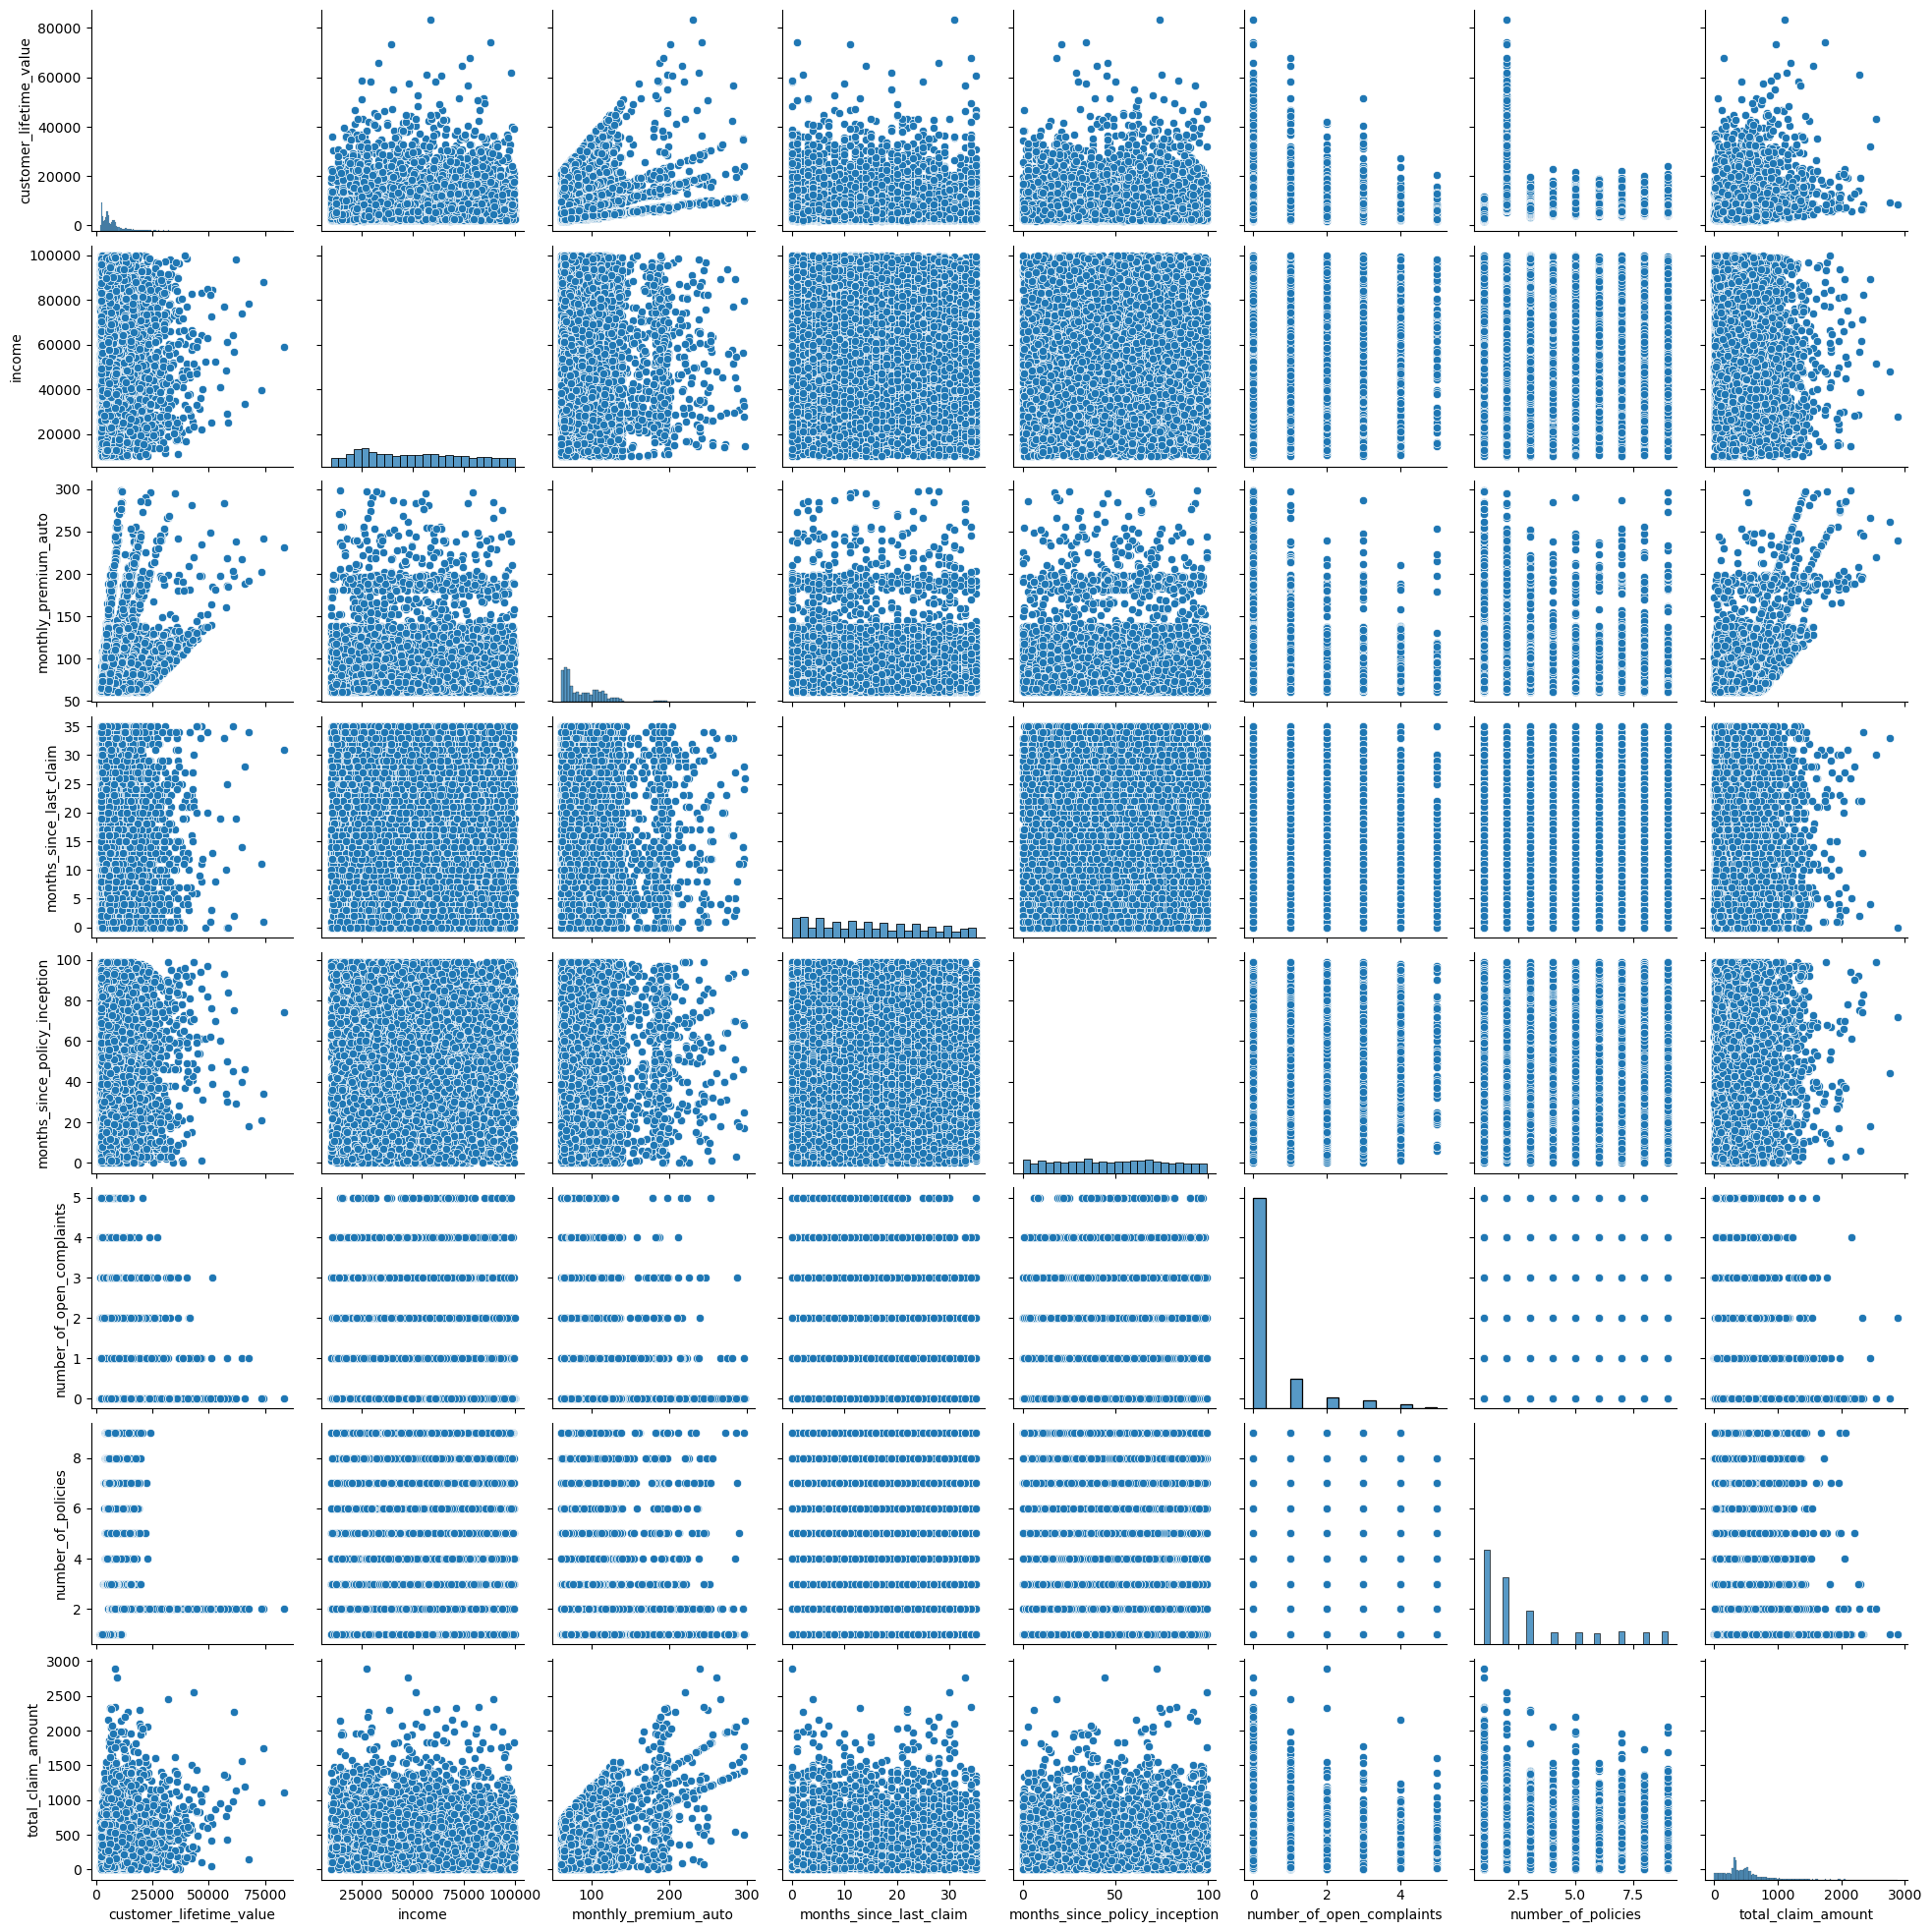

In [6]:
sns.pairplot(hk_df.select_dtypes(np.number)) # pairplot generates a grid of scatter plots for all numerical variables except on the diagonal where it displays distributions

<b> plotting the correlation heatmap

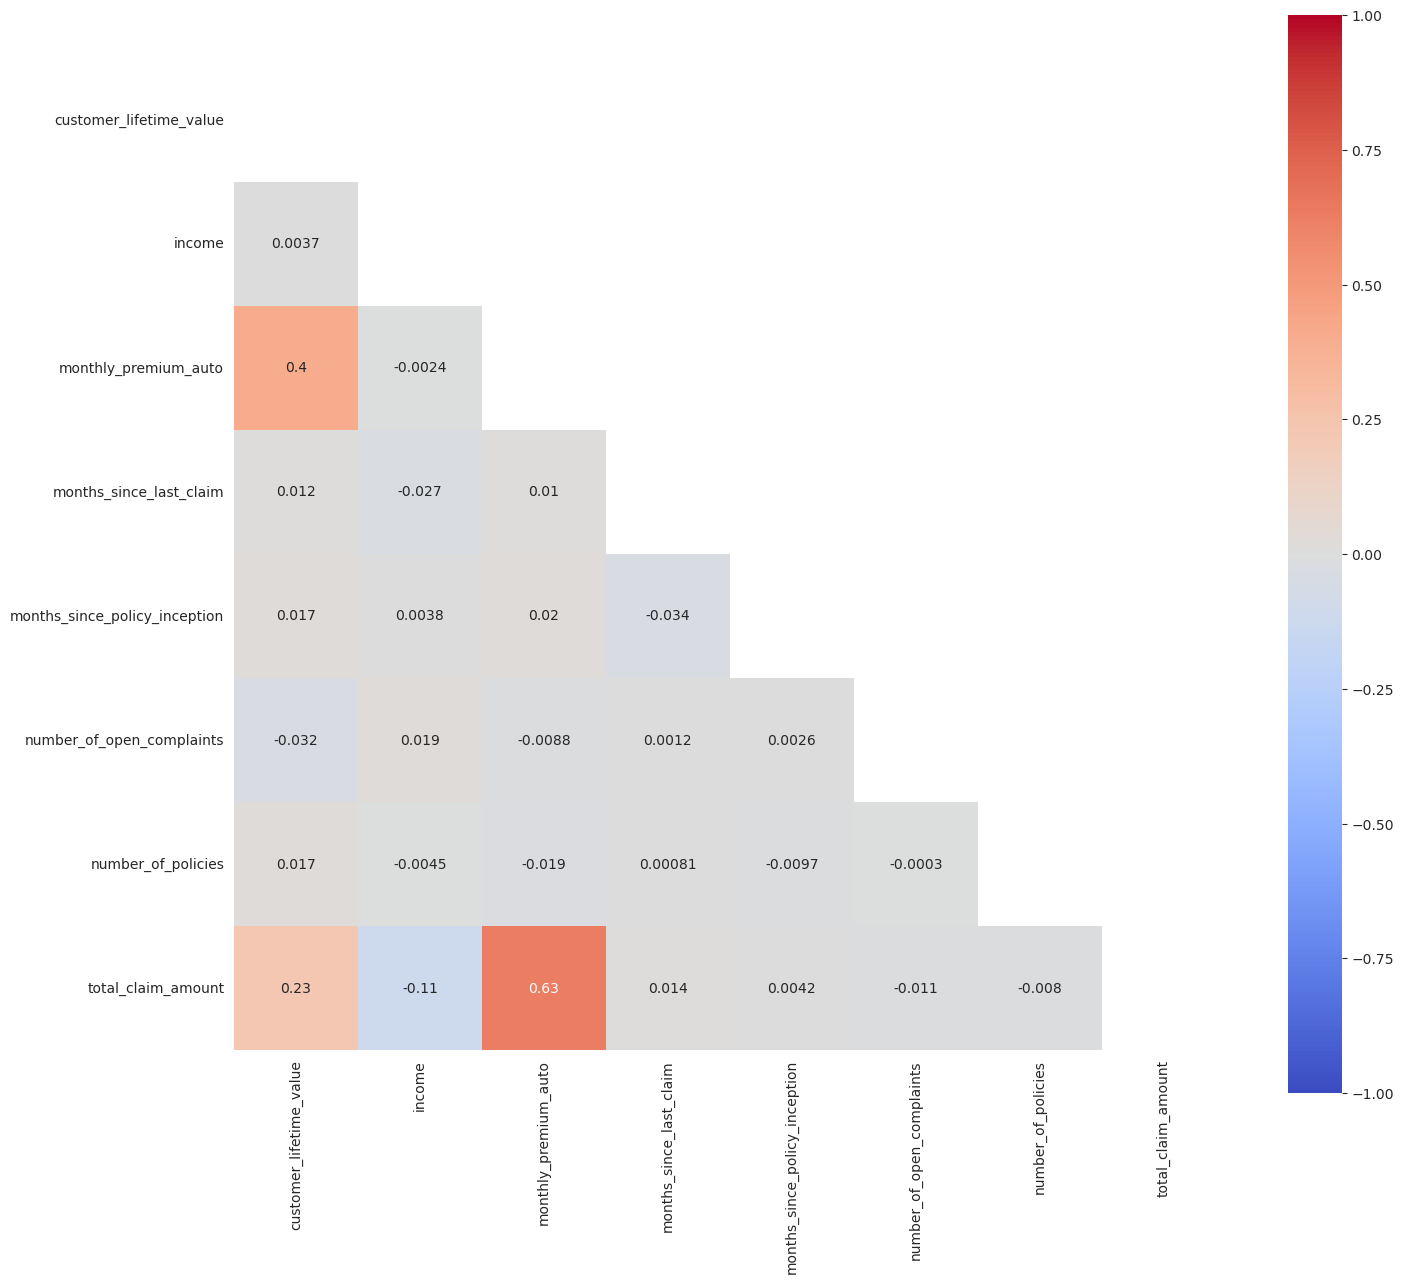

In [7]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

<b> removing highly correlated columns


In [8]:
CORR_THRESH = 0.80
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
hk_df.drop(corrd_cols,axis=1,inplace=True)
hk_df.columns

Index(['region', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'month', 'employment_status',
       'gender', 'income', 'location_code', 'marital_status',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

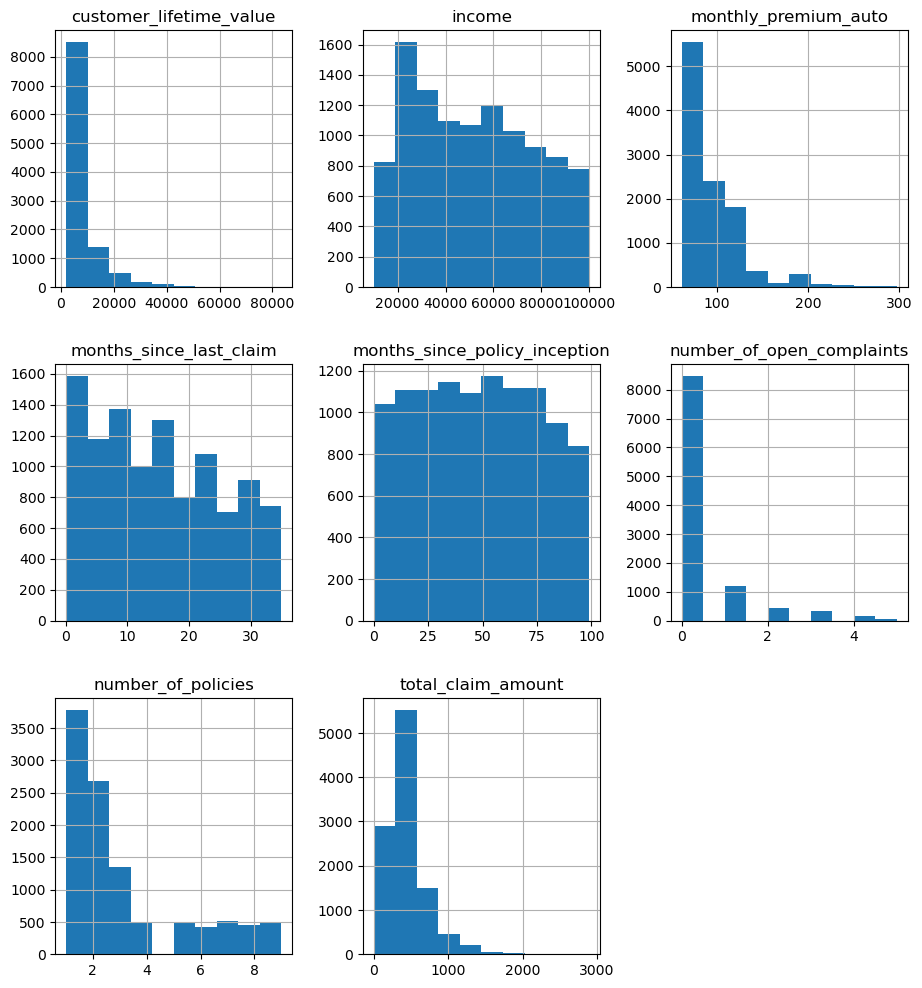

In [9]:
hk_df.hist(figsize=(11,12))

<b> distribution of customer_lifetime_value is skewed towards lower life time value 

C:\Users\aguil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customer_lifetime_value', ylabel='Density'>

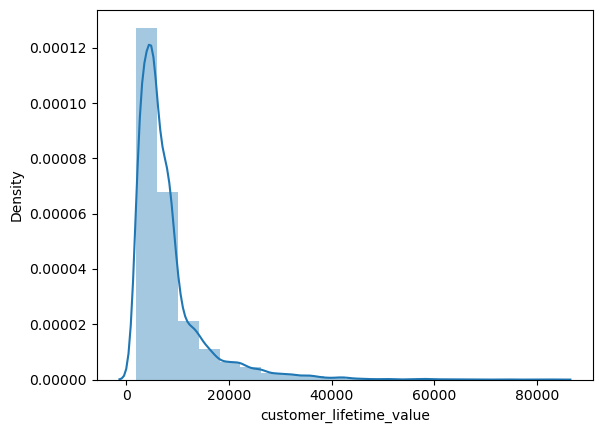

In [10]:
sns.distplot((hk_df['customer_lifetime_value']), bins=20)

## X,y, one-hot, and test/train

In [11]:
X = hk_df.drop('total_claim_amount', axis=1)
y = hk_df.total_claim_amount

In [12]:
#dividing data into numerical and categorical 
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

C:\Users\aguil\AppData\Local\Temp\ipykernel_16860\2609431453.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


 <b> Lab Tuesday 11.04.2023 Spliting numerical values and traingn the model 
Lab Monday_10.04.2023 - Transforming categorical values (nominals and ordinals) into dummies. 



2. One Hot/Label Encoding of the categorical variables in the categoricals data frame that you created in Activity 3. ( Hint: check Dropfirst option).

In [13]:
categoricalX

,region,response,coverage,education,effective_to_date,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,central,no,basic,college,2/18/11,feb,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize
1,west region,no,basic,college,1/18/11,jan,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize
2,east,no,basic,bachelor,2/10/11,feb,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize
3,north west,yes,extended,college,1/11/11,jan,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize
4,north west,no,premium,bachelor,1/17/11,jan,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,1/19/11,jan,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize
10685,north west,no,basic,college,1/6/11,jan,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize
10686,central,no,extended,bachelor,2/6/11,feb,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize
10687,west region,no,premium,college,2/13/11,feb,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize


In [14]:
# 4 droping the colum 'effective_to_date' beacasue it is not possible to change to dumies 
categoricalX=categoricalX.drop(columns=['effective_to_date'])

In [15]:
# 5 Creating a function to replace categorical (ordinal) values 

def replacer(col_name,old_vals,new_vals):
    for i in range(len(old_vals)):
        categoricalX.loc[categoricalX[col_name] == old_vals[i], col_name] = new_vals[i]
    
    return categoricalX[col_name]

In [16]:
categoricalX['coverage'].unique()


array(['basic', 'extended', 'premium'], dtype=object)

In [17]:
categoricalX.month.unique()

array(['feb', 'jan'], dtype=object)

In [18]:
categoricalX.vehicle_size.unique()

array(['medsize', 'small', 'large'], dtype=object)

In [19]:
categoricalX.education.unique()

array(['college', 'bachelor', 'high school or below', 'doctor', 'master'],
      dtype=object)

In [20]:
# 6 creating a data frame to save the new values of the function 
ordinalsX = pd.DataFrame()

In [21]:
ordinalsX['coverage']=replacer('coverage',list(categoricalX.coverage.unique()), [0,1,2] )

In [22]:
ordinalsX['education'] = replacer('education', list(categoricalX.education.unique()), [1,2,0,4,3])

In [23]:
ordinalsX['month'] = replacer('month', list(categoricalX.month.unique()), [1,0])

In [24]:
ordinalsX['vehicle_size'] = replacer('vehicle_size', list(categoricalX.vehicle_size.unique()), [1,0,2])

In [25]:
ordinalsX

,coverage,education,month,vehicle_size
0,0,1,1,1
1,0,1,0,1
2,0,2,1,1
3,1,1,0,1
4,2,2,0,1
...,...,...,...,...
10684,2,2,0,1
10685,0,1,0,1
10686,1,2,1,1
10687,2,1,1,1


In [26]:
numericalX

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,4809,48029,61,7,52,0,9
1,2228,92260,64,3,26,0,1
2,14947,22139,100,34,31,0,2
3,22332,49078,97,10,3,0,2
4,9025,23675,117,33,31,0,7
...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,0,7
10685,5259,61146,65,7,68,0,6
10686,23893,39837,201,11,63,0,2
10687,11971,64195,158,0,27,4,6


In [27]:
categoricalX = categoricalX.drop('education', axis=1)
categoricalX = categoricalX.drop('month', axis=1)
categoricalX = categoricalX.drop('vehicle_size', axis=1)
categoricalX = categoricalX.drop('coverage', axis=1)
categoricalX

,region,response,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class
0,central,no,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car
1,west region,no,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car
2,east,no,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv
3,north west,yes,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car
4,north west,no,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car
...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car
10685,north west,no,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car
10686,central,no,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv
10687,west region,no,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv


In [29]:
categoricalX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region             10689 non-null  object
 1   response           10689 non-null  object
 2   employment_status  10689 non-null  object
 3   gender             10689 non-null  object
 4   location_code      10689 non-null  object
 5   marital_status     10689 non-null  object
 6   policy_type        10689 non-null  object
 7   policy             10689 non-null  object
 8   renew_offer_type   10689 non-null  object
 9   sales_channel      10689 non-null  object
 10  vehicle_class      10689 non-null  object
dtypes: object(11)
memory usage: 918.7+ KB


In [34]:
pd.get_dummies(categoricalX,drop_first=True)

,region_east,region_north west,region_west region,response_yes,employment_status_employed,employment_status_medical leave,employment_status_retired,employment_status_unemployed,gender_m,location_code_suburban,...,renew_offer_type_offer3,renew_offer_type_offer4,sales_channel_branch,sales_channel_call center,sales_channel_web,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car
0,0,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0
3,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,1,1,0,0,0,0
10685,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10686,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
10687,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [36]:
remove_outliers(X)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> None

In [33]:
X = pd.concat([pd.get_dummies(categoricalX,drop_first=True),
               remove_outliers(X), ordinalsX],
              axis=1)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> None

In [28]:
X

,region_east,region_north west,region_west region,response_yes,employment_status_employed,employment_status_medical leave,employment_status_retired,employment_status_unemployed,gender_m,location_code_suburban,...,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,coverage,education,month,vehicle_size
0,0,0,0,0,1,0,0,0,1,1,...,48029,61.0,7,52,NaN,NaN,0,1,1,1
1,0,0,1,0,0,0,0,1,0,1,...,92260,64.0,3,26,NaN,1.0,0,1,0,1
2,1,0,0,0,1,0,0,0,1,1,...,22139,100.0,34,31,NaN,2.0,0,2,1,1
3,0,1,0,1,1,0,0,0,1,1,...,49078,97.0,10,3,NaN,2.0,1,1,0,1
4,0,1,0,0,0,1,0,0,0,1,...,23675,117.0,33,31,NaN,7.0,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,0,0,0,0,0,0,1,0,1,...,61541,NaN,12,40,NaN,7.0,2,2,0,1
10685,0,1,0,0,1,0,0,0,0,0,...,61146,65.0,7,68,NaN,6.0,0,1,0,1
10686,0,0,0,0,1,0,0,0,0,0,...,39837,NaN,11,63,NaN,2.0,1,2,1,1
10687,0,0,1,0,1,0,0,0,0,0,...,64195,158.0,0,27,NaN,6.0,2,1,1,1


In [30]:
X.isna().any()

region_east                        False
region_north west                  False
region_west region                 False
response_yes                       False
employment_status_employed         False
employment_status_medical leave    False
employment_status_retired          False
employment_status_unemployed       False
gender_m                           False
location_code_suburban             False
location_code_urban                False
marital_status_married             False
marital_status_single              False
policy_type_personal auto          False
policy_type_special auto           False
policy_corporate l2                False
policy_corporate l3                False
policy_personal l1                 False
policy_personal l2                 False
policy_personal l3                 False
policy_special l1                  False
policy_special l2                  False
policy_special l3                  False
renew_offer_type_offer2            False
renew_offer_type

In [31]:
na_idcs = X[X.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs)
y = pd.DataFrame(y).drop(na_idcs)

In [33]:
X

,region_east,region_north west,region_west region,response_yes,employment_status_employed,employment_status_medical leave,employment_status_retired,employment_status_unemployed,gender_m,location_code_suburban,...,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,coverage,education,month,vehicle_size


In [32]:
# test-train split
#tt_ratio id defined above 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(3)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.